In [3]:
import pandas as pd # read the csv
import re # regex to detect username, url, html entity 
import nltk # to use word tokenize (split the sentence into words)
import tensorflow as tf
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

from keras.utils import to_categorical
from keras import backend as K

In [4]:
data = pd.read_csv("train.csv")
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [5]:
(data
     .groupby("class")
     .agg(
        hate_speech_count=("hate_speech_count", "mean"),
        offensive_language_count=("offensive_language_count", "mean"),
        neither_count=("neither_count", "mean"),
     )
     .round(1)
)

,hate_speech_count,offensive_language_count,neither_count
class,,,
0,2.3,0.8,0.1
1,0.2,3.0,0.1
2,0.1,0.3,2.8


From here we can tell that class 0 is hate speech, class 1 is offensive language, and class 2 is neutral

In [6]:
# merge class 0 and 1 to classify it as offensive hate speech
data = (data
    .assign(
        class_=data["class"].map({
            0:1,
            1:1,
            2:0
        })
    )
    .drop(columns=["class"])
    .rename(columns={"class_": "class"})
)

data["class"].value_counts(dropna=False, normalize=True).sort_index()

class
0    0.167978
1    0.832022
Name: proportion, dtype: float64

Now we have class 0 is neutral and class 1 is offensive hate speech. Let's specify this

In [7]:
class_map = {
    0: "neutral", 
    1: "offensive and hate speech"
}

In [8]:
tweet = list(data['tweet'])
labels = list(data['class'])

**CLEAN THE DATA**

In [9]:
tweet

["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
 '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!',
 '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit',
 '!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny',
 '!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;',
 '!!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"',
 '!!!!!!"@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!"',
 "!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;",
 '" &amp; you might not get ya bitch back &amp; thats t

In [10]:
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
# add rt to remove retweet in dataset (noise)
stop_words.add("RT")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    # text = text.replace("RT", '')
    # text = text.replace("user", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # remove the @xxx 
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/namhoangngo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# call the cleaning function
clean_tweet = preprocess(tweet)
clean_tweet

['RT woman shouldnt complain cleaning house . man always take trash .',
 'RT boy dats cold.tyga dwn bad cuffin dat hoe 1st place',
 'RT Dawg RT ever fuck bitch start cry ? confused shit',
 'RT look like tranny',
 'RT shit hear might true might faker bitch told ya',
 'shit blows meclaim faithful somebody still fucking hoes',
 'sit HATE another bitch got much shit going',
 'cause Im tired big bitches coming us skinny girls',
 'might get ya bitch back thats',
 ': hobbies include : fighting Mariam bitch',
 'Keeks bitch curves everyone lol walked conversation like . Smh',
 'Murda Gang bitch Gang Land',
 'hoes smoke losers ? yea . go IG',
 'bad bitches thing like',
 'bitch get',
 'bitch nigga miss',
 'bitch plz whatever',
 'bitch love',
 'bitches get cut everyday B',
 'black bottle bad bitch',
 'broke bitch cant tell nothing',
 'cancel bitch like Nino',
 'cant see hoes wont change',
 'fuck bitch dont even suck dick Kermit videos bout fuck IG',
 'got ya bitch tip toeing hardwood floors',
 'pu

Split data into train and test

Epoch 1/20
310/310 [==============================] - 18s 27ms/step - loss: 0.0227 - accuracy: 0.9186 - val_loss: 0.0162 - val_accuracy: 0.9377
Epoch 2/20
310/310 [==============================] - 10s 33ms/step - loss: 0.0081 - accuracy: 0.9725 - val_loss: 0.0223 - val_accuracy: 0.9421
Epoch 3/20
310/310 [==============================] - 8s 27ms/step - loss: 0.0044 - accuracy: 0.9856 - val_loss: 0.0233 - val_accuracy: 0.9401
Epoch 4/20
155/155 [==============================] - 1s 3ms/step - loss: 0.0318 - accuracy: 0.9354
Test Loss: 0.03178110346198082
Test Accuracy: 0.9354448318481445


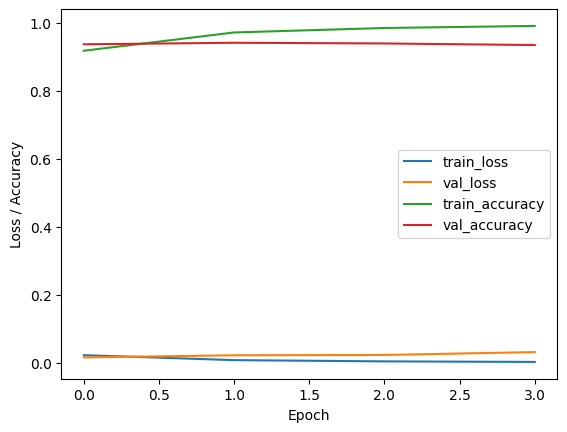

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import losses
from tensorflow.keras.losses import BinaryFocalCrossentropy


# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_tweet)
X_tokenized = tokenizer.texts_to_sequences(clean_tweet)

# Pad the tokenized sequences to make them all the same length
max_length = 15  # Define your desired maximum sequence length
X_padded = pad_sequences(X_tokenized, maxlen=max_length)

# Convert the target labels to arrays
y_array = np.array(labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_array, test_size=0.2, random_state=42)

# Create the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 64))
model.add(Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Configure the BinaryFocalCrossentropy loss with class balancing
loss_function = BinaryFocalCrossentropy(gamma=2, apply_class_balancing=True)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot training history
plt.plot(model_history.history['loss'], label='train_loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.plot(model_history.history['accuracy'], label='train_accuracy')
plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()


In [67]:
# Define the test inputs
test1 = "@CNN The weather forecast predicts sunshine and clear skies for tomorrow."
test2 = "I enjoy reading books and spending time in nature #selflove."
test3 = "i love you
"
test4 = "I can't stand those immigrants ruining our country fuck them!!!"
test5 = "@melanie You damn broke bitch you should die LOL"

# Put the test inputs into a list
docs = [test1, test2, test3, test4, test5]

# Tokenize the test inputs
docs_processed = tokenizer.texts_to_sequences(docs)

# Pad the tokenized sequences
docs_processed = pad_sequences(docs_processed, maxlen=max_length, padding="post", truncating="post")

# Make predictions
y_pred = model.predict(docs_processed)

# Threshold for classification
threshold = 0.5

# Define labels
class_map = {0: "Not Hate Speech", 1: "Hate Speech"}

print("\nHate speech and offensive language detection algorithm.")
print("Model prediction:")
for doc, pred in zip(docs, y_pred):
    label = 1 if pred >= threshold else 0
    print(f"{doc: <75} : predicted as {class_map[label]} with confidence {pred[0]:.4f}")


1/1 [==============================] - 0s 112ms/step

Hate speech and offensive language detection algorithm.
Model prediction:
@CNN The weather forecast predicts sunshine and clear skies for tomorrow.   : predicted as Not Hate Speech with confidence 0.1464
I enjoy reading books and spending time in nature #selflove.                : predicted as Not Hate Speech with confidence 0.2812
fuck yỏur mom                                                               : predicted as Hate Speech with confidence 0.9122
I can't stand those immigrants ruining our country fuck them!!!             : predicted as Hate Speech with confidence 0.9215
@melanie You damn broke bitch you should die LOL                            : predicted as Hate Speech with confidence 0.9404


In [62]:
#aplly_class_balancing 
#BinaryFocalCrossentropy